# 梯度中间量应用：原子的电子态密度测评程序

我们这一节将会回顾梯度中间量：弛豫密度 $D_{\mu \nu}^\mathrm{PT2+}$ 的应用。这也是作者曾经辅助完成的一项工作：

- **Su**

    这篇文档讨论双杂化，特别是 XYG3 型泛函在闭壳层原子体系下，密度与能量均有较好表现；展示了密度泛函在当前的测评体系下，确实地沿着 Predew 提出的 Jacob 阶梯进展的现状。

    > Su, N. Q.; Zhu, Z. & Xu, X.
    >
    > Doubly hybrid density functionals that correctly describe both density and energy for atoms
    >
    > *Proc. Natl. Acad. Sci. U.S.A.* **2018**, *115*, 2287-2292
    >
    > doi: [10.1073/pnas.1713047115](https://dx.doi.org/10.1073/pnas.1713047115)

这篇文章与下述文章有直接的关系：

- **Medvedev**

    这篇文档系统地测评了各种泛函在闭壳层原子体系下的密度与能量，指出一般地泛函沿着 Jacob 阶梯进展，但由于不同的泛函设计理念，导致许多 (特别是近年) 泛函存在比较严重、违背物理的设计问题。

    > Medvedev, M. G.; Bushmarinov, I. S.; Sun, J.; Perdew, J. P. & Lyssenko, K. A.
    >
    > Density functional theory is straying from the path toward the exact functional
    >
    > *Science* **2017**, *355*, 49-52
    >
    > doi: [10.1126/science.aah5975](https://dx.doi.org/10.1126/science.aah5975)

在这份程序文档中，我们仅仅打算回顾作者在 Su 文章中所作的工作的部分，即绘制各种泛函 (包括 XYG3 型泛函) 的密度格点图进行比较。我们在这里仅仅讨论技术上的问题。原文使用的是 NWChem 进行计算，我们将会用 PySCF 与 pyxdh 重现这部分计算过程。

## 准备工作

这一节的测评将会计算 CCSD 的弛豫密度；事实上作者目前还尚未仔细推导过 CCSD 的密度公式，我们就借用 PySCF 中的耦合簇模块 `cc` 来生成 CCSD 的弛豫密度。对于 MP2 方法或 XYG3 型泛函，我们使用 `GradMP2` 与 `GradXDH`生成弛豫密度。

In [1]:
%matplotlib notebook

from pyscf import gto, scf, dft, lib
import numpy as np
from functools import partial
import warnings
from matplotlib import pyplot as plt
from IPython.display import Image
from pyxdh.DerivOnce import GradSCF, GradMP2, GradXDH

np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 20 / 8])
np.allclose = partial(np.allclose, atol=1e-6, rtol=1e-4)
np.set_printoptions(5, linewidth=150, suppress=True)
warnings.filterwarnings("ignore")

我们这一节只测评 Ne 原子；其它闭壳层原子也可以用相同的方式测评。受制于 libcint 库对 H 壳层轨道的处理可能存在问题，相较于原文 aug-cc-pωCV5Z，我们去除了其中两个 H 轨道信息。

In [2]:
mol = gto.Mole()
mol.atom = """
Ne 0. 0. 0.
"""
with open("./assets/Ne_basis.txt") as f:
    mol.basis = gto.basis.parse(f.read())
mol.verbose = 0
mol.build()
nao = nmo = mol.nao

## RHF 电子态密度计算

### 计算实例与基本变量

我们首先给出 RHF 与 CCSD 的计算实例 `mf_rhf`；并定义 `C_rhf` 为 RHF 下的轨道系数 $C_{\mu p}$，以及 `mo_occ` 为电子占据数。

In [3]:
mf_rhf = scf.RHF(mol).run()
C_rhf, mo_occ = mf_rhf.mo_coeff, mf_rhf.mo_occ

我们以前不太提及变量 `mo_occ`；但它在现在电子态密度的计算中非常实用。它实际上可以看做是关于 $p$ 的向量 $2 \delta_{p \in \mathrm{occ}}$。我们知道 Ne 原子是 10 电子体系，因此在 RHF 下前 5 根轨道的电子占据数是 2。`mo_occ` 的维度是 $(p, )$ 维即分子轨道数量维度，但只有占据轨道部分 (前 5 根) 填入 2 个电子占据：

In [4]:
mo_occ[:10]

array([2., 2., 2., 2., 2., 0., 0., 0., 0., 0.])

一个衍生的概念是分子轨道下的密度矩阵 $D_{pq} = 2 \delta_{pq} \delta_{p \in \mathrm{occ}}$。我们以前经常写原子轨道下的密度矩阵为 $D_{\mu \nu} = C_{\mu i} C_{\nu i}$；但我们也可以写 $D_{\mu \nu} = C_{\mu p} D_{\mu \nu} C_{\nu q}$。

In [5]:
np.allclose(C_rhf @ np.diag(mo_occ) @ C_rhf.T, mf_rhf.make_rdm1())

True

`mo_occ` 变量将在下一小节经常使用到。

### 径向轨道格点

我们评测电子态密度的依据是径向密度大小。我们选取 50000 个格点，它们可以沿着任意轴向 (我们测评的是非简并闭壳层原子，因此一定具有球对称性，我们不妨选取 $x$ 轴向)，平均地分布在 0 - 10 Angstrom 之间。从 0 到 10 Angstrom 的点我们用 `rad_x` 记录；但这些点的单位选取 Bohr，因此大约是 0 - 18.90 Bohr：

In [6]:
rad_ngrid = 50000
rad_x = np.linspace(0, 10 / lib.param.BOHR, rad_ngrid)
rad_x

array([ 0.     ,  0.00038,  0.00076, ..., 18.89651, 18.89688, 18.89726])

将这些距离化为具体的、三维的格点 `rad_coord`：

In [7]:
rad_coord = np.array([rad_x, np.zeros(rad_ngrid), np.zeros(rad_ngrid)]).T
rad_coord

array([[ 0.     ,  0.     ,  0.     ],
       [ 0.00038,  0.     ,  0.     ],
       [ 0.00076,  0.     ,  0.     ],
       ...,
       [18.89651,  0.     ,  0.     ],
       [18.89688,  0.     ,  0.     ],
       [18.89726,  0.     ,  0.     ]])

我们的目标是获得各个方法下的密度格点，因此我们需要计算轨道导数 `rad_ao_0` $\phi_{\mu}$, `rad_ao_1` $\phi_{t \mu}$, `rad_ao_2` $\phi_{tr \mu}$。我们可以使用 PySCF 自带的 `eval_ao` 函数：

In [8]:
ni = dft.numint.NumInt()
rad_ao = ni.eval_ao(mol, rad_coord, deriv=2)
rad_ao.shape

(10, 50000, 159)

In [9]:
rad_ao_0 = rad_ao[0]
rad_ao_1 = rad_ao[1:4]
rad_ao_2 = np.array([
    [rad_ao[4], rad_ao[5], rad_ao[6]],
    [rad_ao[5], rad_ao[7], rad_ao[8]],
    [rad_ao[6], rad_ao[8], rad_ao[9]],
])

### 密度格点 (RHO) 绘图

我们先绘制 RHF 的电子态密度格点。首先，我们定义函数 `get_rad_rho` 函数，它输入原子轨道下的密度矩阵 $D_{\mu \nu}$，输出密度格点

$$
\rho = \phi_\mu \phi_\nu D_{\mu \nu}
$$

In [10]:
def get_rad_rho(dm):
    return np.einsum("gu, gv, uv -> g", rad_ao_0, rad_ao_0, dm)

代入 RHF 密度，就可以得到格点 `rad_rho_rhf` $\rho^\mathrm{HF}$：

In [11]:
D_rhf = mf_rhf.make_rdm1()
rad_rho_rhf = get_rad_rho(D_rhf)

但 $\rho^\mathrm{HF}$ (或者我们显示地将距离表示出来 $\rho^\mathrm{HF} (r)$) 是径向密度，而非径向分布；我们测评的依据是径向分布 `dist_rho_rhf` $4 \pi r^2 \rho^\mathrm{HF} (r)$。

但在此之前，我们需要对单位作分析。我们上述计算过程中使用的都是 Bohr 单位；但绘图与测评过程中，则需要转化为 Angstrom 单位。注意到 `rad_rho_rhf` $\rho^\mathrm{HF} (r)$ 的单位是 $\mathsf{Bohr}^{-3}$，因为

$$
\int 4 \pi r^2 \rho^\mathrm{HF} (r) \, \mathrm{d} r = n_\mathrm{elec}
$$

In [12]:
(4 * np.pi * rad_x**2 * rad_rho_rhf).sum() * (rad_x[1] - rad_x[0])

10.000000000000112

因此，$4 \pi r^2 \rho^\mathrm{HF} (r)$ 的量纲为 $[\mathrm{L}]^{-1}$，因此转化为 Angstrom 单位就通过除以 Bohr 换算数就可以得到：

In [13]:
dist_rho_rhf = 4 * np.pi * rad_rho_rhf * rad_x**2 / lib.param.BOHR

这样，我们就可以绘制 CCSD 的密度格点图像了：

<IPython.core.display.Javascript object>


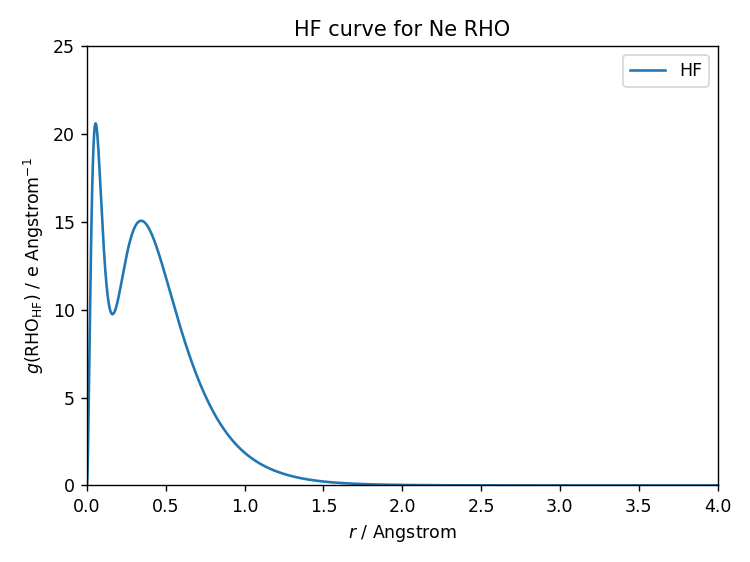

In [14]:
fig, ax = plt.subplots(figsize=(6, 4.5))
ax.plot(rad_x * lib.param.BOHR, dist_rho_rhf, label="HF")
ax.set_xlim([0, 4]); ax.set_ylim([0, 25])
ax.set_title("HF curve for Ne RHO")
ax.set_xlabel("$r$ / Angstrom")
ax.set_ylabel("$g(\mathrm{RHO}_\mathrm{HF})$ / e Angstrom$^{-1}$")
ax.legend(); fig.tight_layout()

这也与 Medvedev 文章 [Supporting Materials](https://science.sciencemag.org/highwire/filestream/688792/field_highwire_adjunct_files/4/Medvedev.SM.pdf) Fig S1 右上方图片近乎一致 (但我们使用的是 RHF 而非 CCSD 方法)。

### 密度梯度 (GRD) 绘图

现在我们对 RHF 的密度梯度绘图。密度梯度定义为

$$
\rho_t = 2 \phi_{t \mu} \phi_\nu D_{\mu \nu}
$$

但用于测评的格点是通过下述方式导出的：

$$
|\nabla \rho| = \sqrt{\sum_{t \in \{ x, y, z \}} \rho_t^2}
$$

In [15]:
def get_rad_grd(dm):
    return np.linalg.norm(2 * np.einsum("tgu, gv, uv -> tg", rad_ao_1, rad_ao_0, dm), axis=0)

In [16]:
rad_grd_rhf = get_rad_grd(D_rhf) 

类似于前文，我们使用 $4 \pi r^2 |\nabla \rho|$ 来作格点梯度测评：

<div class="alert alert-warning">

**单位换算存疑**

可以看到下面的代码仅仅除以了一次 Bohr 与 Angstrom 单位的换算数；但 $4 \pi r^2 |\nabla \rho|$ 的量纲为 $[\mathrm{L}]^{-2}$，并且我们在作单位换算之前统一都使用了原子单位，即长度为 Bohr，因此这里应该是要作两次单位换算。但如果只作一次单位换算，可以与 Medvedev 的 Science 作正确的核对。后面的 Laplacian 量计算也同样如此。

</div>

In [17]:
dist_grd_rhf = 4 * np.pi * get_rad_grd(D_rhf) * rad_x**2 / lib.param.BOHR

格点梯度的绘制如下：

<IPython.core.display.Javascript object>


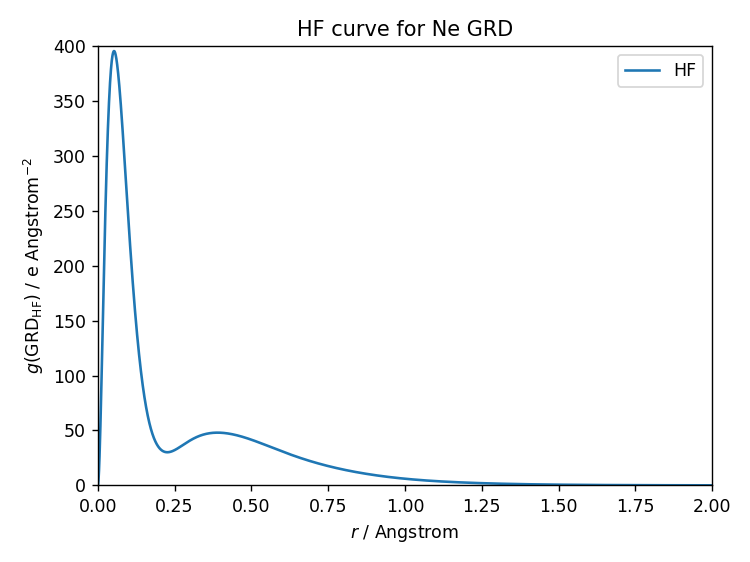

In [18]:
fig, ax = plt.subplots(figsize=(6, 4.5))
ax.plot(rad_x * lib.param.BOHR, dist_grd_rhf, label="HF")
ax.set_xlim([0, 2]); ax.set_ylim([0, 400])
ax.set_title("HF curve for Ne GRD")
ax.set_xlabel("$r$ / Angstrom")
ax.set_ylabel("$g(\mathrm{GRD}_\mathrm{HF})$ / e Angstrom$^{-2}$")
ax.legend(); fig.tight_layout()

### Laplacian 量 (LR) 绘制

密度的二阶导数量如下：

$$
\rho_{tr} = (2 \phi_{tr \mu} \phi_{\nu} + 2 \phi_{t \mu} \phi_{r \nu}) D_{\mu \nu}
$$

但用于测评的格点是通过下述方式给出的：

$$
|\nabla^2 \rho| = \rho_{xx} + \rho_{yy} + \rho_{zz}
$$

In [19]:
def get_rad_lr(dm):
    lr_grid = (
        + 2 * np.einsum("trgu, gv, uv -> trg", rad_ao_2, rad_ao_0, dm)
        + 2 * np.einsum("tgu, rgv, uv -> trg", rad_ao_1, rad_ao_1, dm))
    return lr_grid.trace(axis1=0, axis2=1)

In [20]:
rad_lr_rhf = get_rad_lr(D_rhf)

In [21]:
dist_lr_rhf = 4 * np.pi * rad_lr_rhf * rad_x**2 / lib.param.BOHR

格点的绘制如下：

<IPython.core.display.Javascript object>


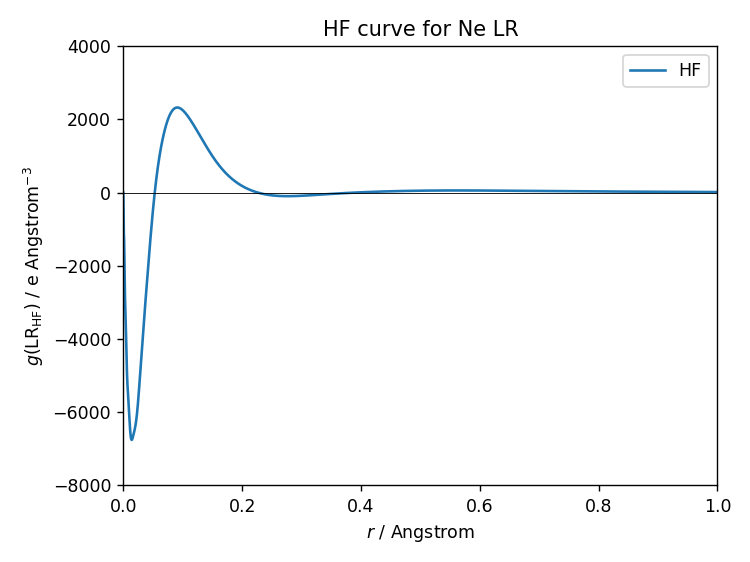

In [22]:
fig, ax = plt.subplots(figsize=(6, 4.5))
ax.plot(rad_x * lib.param.BOHR, dist_lr_rhf, label="HF")
ax.plot([0, 1], [0, 0], color="black", linewidth=0.5)
ax.set_xlim([0, 1]); ax.set_ylim([-8000, 4000])
ax.set_title("HF curve for Ne LR")
ax.set_xlabel("$r$ / Angstrom")
ax.set_ylabel("$g(\mathrm{LR}_\mathrm{HF})$ / e Angstrom$^{-3}$")
ax.legend(); fig.tight_layout()

## 泛函测评过程

### 作为标准的 CCSD 结果

关于 CCSD 是如何计算的，这里我们不作详细展开。我们分别将 CCSD 的密度 (RHO)、梯度 (GRD)、Laplacian (LR) 储存于 `dist_rho_ccsd`, `dist_grd_ccsd`, `dist_lr_ccsd` 中。CCSD 的这些格点将会作为参照格点，用以评判其它格点的优劣。

In [23]:
with open("assets/RHO-Ne.txt", "r") as f:
    dist_rho_ccsd = np.array([float(line.split()[2]) for line in f.readlines()]) / lib.param.BOHR
with open("assets/GRD-Ne.txt", "r") as f:
    dist_grd_ccsd = np.array([float(line.split()[2]) for line in f.readlines()]) / lib.param.BOHR
with open("assets/LR-Ne.txt", "r") as f:
    dist_lr_ccsd = np.array([float(line.split()[2]) for line in f.readlines()]) / lib.param.BOHR

### 各方法密度矩阵的导出

我们先定义下述函数，它将生成 $(99, 590)$ 的格点。我们知道，原始工作中选用的是在 Gaussian 中的 UltraFine 格点，$(99, 590)$ 相对来说比较接近 UltraFine 格点。

In [24]:
def mol_to_grids(mol, atom_grid=(99, 590)):
    grids = dft.Grids(mol)
    grids.atom_grid = atom_grid
    grids.becke_scheme = dft.gen_grid.stratmann
    grids.prune = None
    grids.build()
    return grids
grids = mol_to_grids(mol)

下述函数是通过输入分子、泛函名称来进行计算，从而输出密度矩阵：

In [25]:
def mol_to_scf(mol, xc):
    scf_eng = dft.RKS(mol)
    scf_eng.grids = mol_to_grids(mol)
    scf_eng.xc = xc
    scf_eng.conv_tol = 1e-10
    return scf_eng.run()

对于自洽场方法 (PBE, B3LYP) 而言，我们就很容易获得其密度矩阵：

In [26]:
D_pbe0 = mol_to_scf(mol, "PBE0").make_rdm1()
D_b3lyp = mol_to_scf(mol, "B3LYPg").make_rdm1()

而对于 MP2 而言，我们需要 PySCF 之外的工具了，这里我们用 `GradMP2` 来构成实例。当然用 `DipoleMP2` 也可以，因为我们的目的是得到弛豫密度，因为弛豫密度不受被求导量的变化而受到影响。

<div class="alert alert-info">

**MP2 弛豫密度目前无法直接通过 PySCF 获得**

对于 `mp.MP2` 来给出 MP2 的计算实例，并通过 `make_rdm1` 给出的密度，该密度相当于 $D_{ij}^\mathrm{MP2}$ 与 $D_{ab}^\mathrm{MP2}$；但它并不包括 $D_{ai}^\mathrm{MP2}$ 或 $D_{ia}^\mathrm{MP2}$。这与 PySCF 给出的 CCSD 密度也不一样。因此，我们还是使用 pyxdh 来计算 MP2 的弛豫密度。

</div>

由于内存消耗庞大，我们需要尽量一次性地求出密度矩阵。对于包含 PT2 贡献的泛函 (或 MP2)，我们需要通过下述方式给出密度矩阵：

$$
D_{\mu \nu}^\mathrm{PT2+} = C_{\mu p} \big( 2 \delta_{pq} \delta_{p \in \mathrm{occ}} + \frac{1}{2} (D_{pq}^\mathrm{PT2+} + D_{pq}^\mathrm{PT2+}) \big) C_{\nu q}
$$

这是因为密度矩阵应当要满足对称性，但 $D_{pq}^\mathrm{PT2+}$ 未必满足这种对称性。

In [27]:
def get_D_resp(mf):
    return mf.C @ (np.diag(mo_occ) + 0.5 * (mf.D_r + mf.D_r.T)) @ mf.C.T

In [28]:
D_mp2 = get_D_resp(GradMP2({"scf_eng": mf_rhf, "cphf_tol": 1e-8}))

对于 B2PLYP 来讲，我们额外定义一下 PT2 相关能系数即可：

In [29]:
D_b2plyp = get_D_resp(GradMP2({"scf_eng": mol_to_scf(mol, "0.53*HF + 0.47*B88, 0.73*LYP"), "cphf_tol": 1e-8, "cc": 0.27}))

但对于 XYG3 型泛函而言，我们还需要定义非自洽部分，对于 XYGJ-OS 与 xDH-PBE0 而言，还需要定义平行自旋 PT2 贡献系数 $c_\mathrm{SS}$ 为零。

In [30]:
def mol_to_nc(mol, xc):
    nc_eng = dft.RKS(mol)
    nc_eng.grids = mol_to_grids(mol)
    nc_eng.xc = xc
    return nc_eng

In [31]:
D_xyg3 = get_D_resp(GradXDH({
    "scf_eng": mol_to_scf(mol, "B3LYPg"),
    "nc_eng": mol_to_nc(mol, "0.8033*HF - 0.0140*LDA + 0.2107*B88, 0.6789*LYP"),
    "cc": 0.3211,
    "cphf_tol": 1e-10}))

In [32]:
D_xygjos = get_D_resp(GradXDH({
    "scf_eng": mol_to_scf(mol, "B3LYPg"),
    "nc_eng": mol_to_nc(mol, "0.7731*HF + 0.2269*LDA, 0.2309*VWN3 + 0.2754*LYP"),
    "cc": 0.4364, "ss": 0.,
    "cphf_tol": 1e-10}))

### 电子态密度 (RHO) 绘图

我们先绘制一下 Medvedev 的 [Supporting Materials](https://science.sciencemag.org/highwire/filestream/688792/field_highwire_adjunct_files/4/Medvedev.SM.pdf) 的 Fig. S1 的右下图片。由于 PySCF 所使用的 libxc 库暂时无法调用 M11 泛函，我们就只对 MP2, PBE0, B3LYP, HF 作绘图。

In [33]:
dict1 = {
    "MP2": (D_mp2, "#0000ff"),
    "PBE0": (D_pbe0, "#008000"),
    "B3LYP": (D_b3lyp, "#ff0000"),
    "HF": (D_rhf, "#00ff00"),
}
dict2 = {
    "MP2": (D_mp2, "#508fc5"),
    "B2PLYP": (D_b2plyp, "#e26b12"),
    "XYG3": (D_xyg3, "#a9a6a5"),
    "XYGJ-OS": (D_xygjos, "#f9b500"),
}

<IPython.core.display.Javascript object>


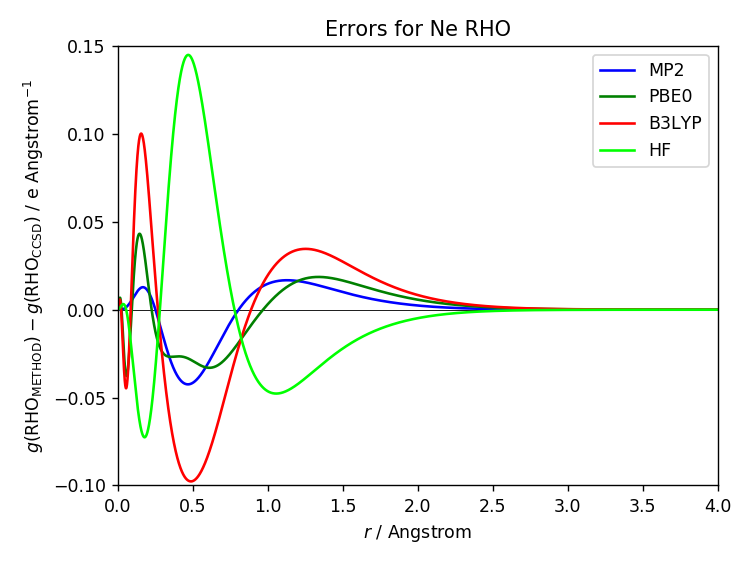

In [34]:
fig, ax = plt.subplots(figsize=(6, 4.5))
ax.plot([0, 10], [0, 0], c="black", linewidth=0.5)
for func, item in dict1.items():
    ax.plot(rad_x * lib.param.BOHR, 4 * np.pi * rad_x**2 * get_rad_rho(item[0]) / lib.param.BOHR - dist_rho_ccsd, c=item[1], label=func)
ax.set_xlim([0, 4]); ax.set_ylim([-0.1, 0.15])
ax.set_title("Errors for Ne RHO")
ax.set_xlabel("$r$ / Angstrom")
ax.set_ylabel("$g(\mathrm{RHO}_\mathrm{METHOD}) - g(\mathrm{RHO}_\mathrm{CCSD})$ / e Angstrom$^{-1}$")
ax.legend(); fig.tight_layout()

下面我们依样画葫芦，绘制包含 PT2 的泛函误差图。这些图片可以参考 Su 的 [Supporting Information](https://www.pnas.org/content/suppl/2018/02/13/1713047115.DCSupplemental) Fig. S1。但由于原文中的 xDH-PBE0 使用了 LibXC 所不包含的泛函，因此没有绘制该泛函的格点。

<IPython.core.display.Javascript object>


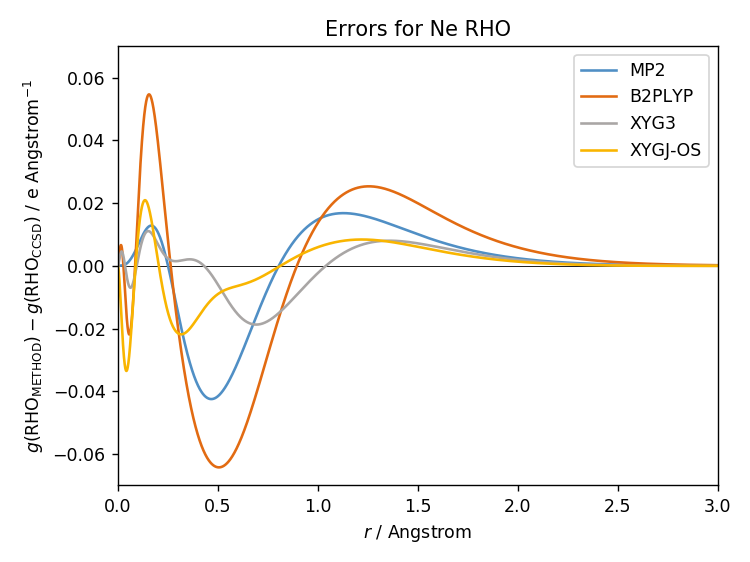

In [35]:
fig, ax = plt.subplots(figsize=(6, 4.5))
ax.plot([0, 10], [0, 0], c="black", linewidth=0.5)
for func, item in dict2.items():
    ax.plot(rad_x * lib.param.BOHR, 4 * np.pi * rad_x**2 * get_rad_rho(item[0]) / lib.param.BOHR - dist_rho_ccsd, c=item[1], label=func)
ax.set_xlim([0, 3]); ax.set_ylim([-0.07, 0.07])
ax.set_title("Errors for Ne RHO")
ax.set_xlabel("$r$ / Angstrom")
ax.set_ylabel("$g(\mathrm{RHO}_\mathrm{METHOD}) - g(\mathrm{RHO}_\mathrm{CCSD})$ / e Angstrom$^{-1}$")
ax.legend(); fig.tight_layout()

### 密度梯度 (GRD) 绘图

<IPython.core.display.Javascript object>


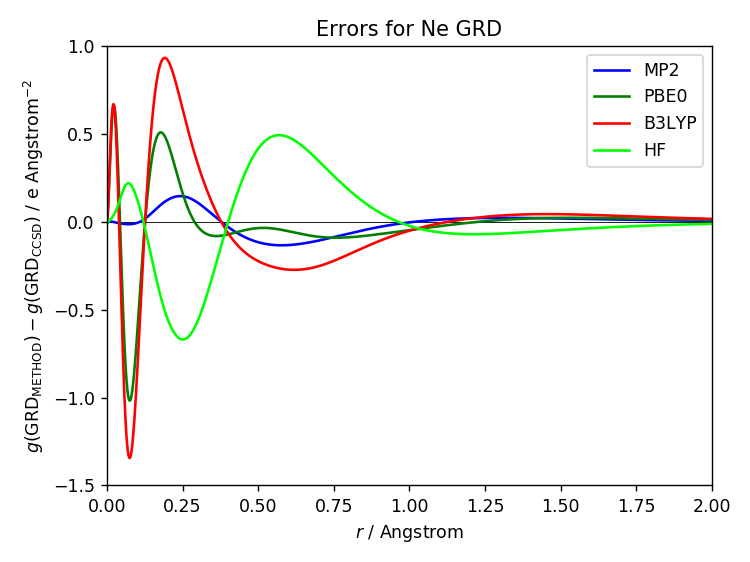

In [36]:
fig, ax = plt.subplots(figsize=(6, 4.5))
ax.plot([0, 10], [0, 0], c="black", linewidth=0.5)
for func, item in dict1.items():
    ax.plot(rad_x * lib.param.BOHR, 4 * np.pi * rad_x**2 * get_rad_grd(item[0]) / lib.param.BOHR - dist_grd_ccsd, c=item[1], label=func)
ax.set_xlim([0, 2]); ax.set_ylim([-1.5, 1])
ax.set_title("Errors for Ne GRD")
ax.set_xlabel("$r$ / Angstrom")
ax.set_ylabel("$g(\mathrm{GRD}_\mathrm{METHOD}) - g(\mathrm{GRD}_\mathrm{CCSD})$ / e Angstrom$^{-2}$")
ax.legend(); fig.tight_layout()

<IPython.core.display.Javascript object>


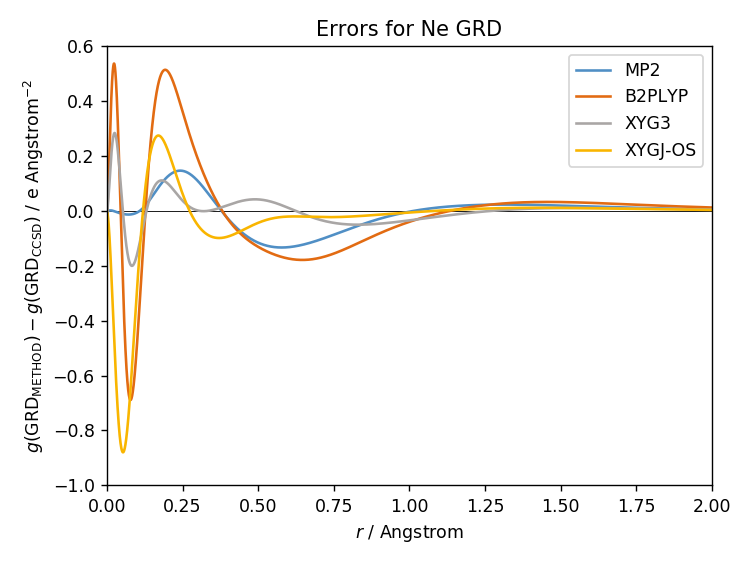

In [37]:
fig, ax = plt.subplots(figsize=(6, 4.5))
ax.plot([0, 10], [0, 0], c="black", linewidth=0.5)
for func, item in dict2.items():
    ax.plot(rad_x * lib.param.BOHR, 4 * np.pi * rad_x**2 * get_rad_grd(item[0]) / lib.param.BOHR - dist_grd_ccsd, c=item[1], label=func)
ax.set_xlim([0, 2]); ax.set_ylim([-1, 0.6])
ax.set_title("Errors for Ne GRD")
ax.set_xlabel("$r$ / Angstrom")
ax.set_ylabel("$g(\mathrm{GRD}_\mathrm{METHOD}) - g(\mathrm{GRD}_\mathrm{CCSD})$ / e Angstrom$^{-2}$")
ax.legend(); fig.tight_layout()

### 密度 Laplacian 量 (LR) 绘图

<IPython.core.display.Javascript object>


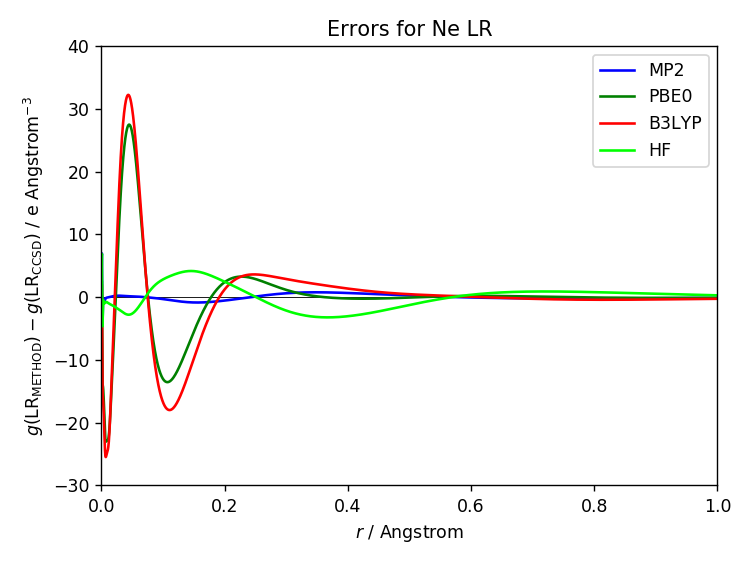

In [38]:
fig, ax = plt.subplots(figsize=(6, 4.5))
ax.plot([0, 10], [0, 0], c="black", linewidth=0.5)
for func, item in dict1.items():
    ax.plot(rad_x * lib.param.BOHR, 4 * np.pi * rad_x**2 * get_rad_lr(item[0]) / lib.param.BOHR - dist_lr_ccsd, c=item[1], label=func)
ax.set_xlim([0, 1]); ax.set_ylim([-30, 40])
ax.set_title("Errors for Ne LR")
ax.set_xlabel("$r$ / Angstrom")
ax.set_ylabel("$g(\mathrm{LR}_\mathrm{METHOD}) - g(\mathrm{LR}_\mathrm{CCSD})$ / e Angstrom$^{-3}$")
ax.legend(); fig.tight_layout()

<IPython.core.display.Javascript object>


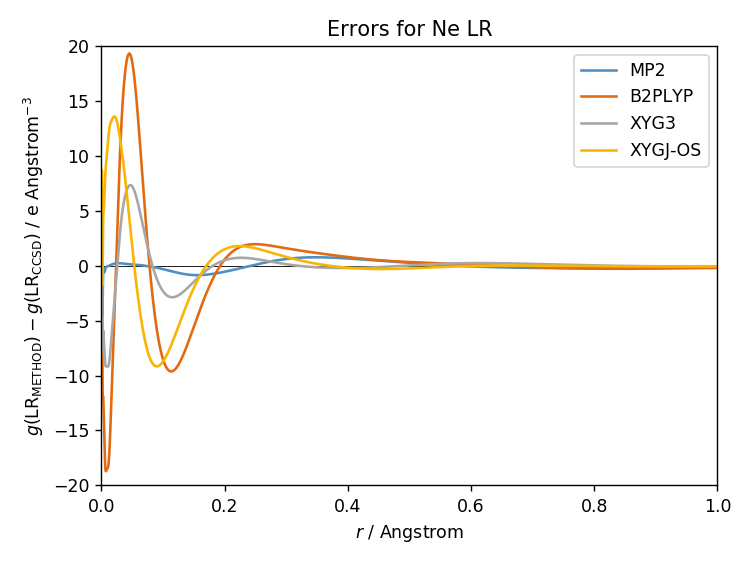

In [39]:
fig, ax = plt.subplots(figsize=(6, 4.5))
ax.plot([0, 10], [0, 0], c="black", linewidth=0.5)
for func, item in dict2.items():
    ax.plot(rad_x * lib.param.BOHR, 4 * np.pi * rad_x**2 * get_rad_lr(item[0]) / lib.param.BOHR - dist_lr_ccsd, c=item[1], label=func)
ax.set_xlim([0, 1]); ax.set_ylim([-20, 20])
ax.set_title("Errors for Ne LR")
ax.set_xlabel("$r$ / Angstrom")
ax.set_ylabel("$g(\mathrm{LR}_\mathrm{METHOD}) - g(\mathrm{LR}_\mathrm{CCSD})$ / e Angstrom$^{-3}$")
ax.legend(); fig.tight_layout()